# Explore here

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import requests
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from pickle import dump

In [2]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
response = requests.get(url).content.decode('utf-8')

file_name = '../data/raw/diabetes.csv'

with open(file_name, 'w') as temp_file:
    temp_file.writelines(response)

In [3]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
df = pd.read_csv(file_name)
pd.set_option('display.max_columns', None)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


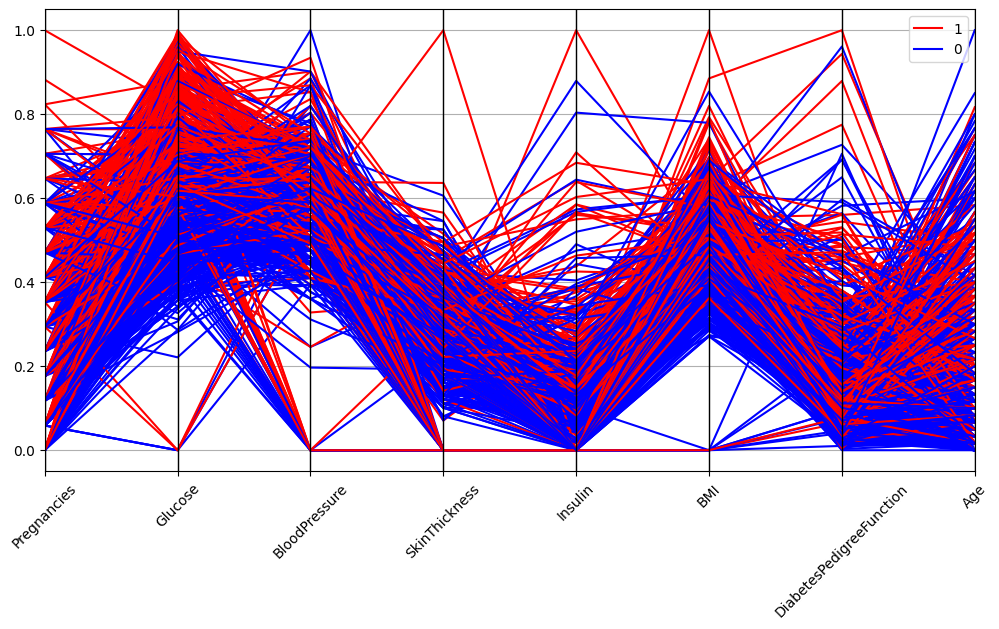

In [5]:
# Procedemos a escalar el dataframe

df_sc = pd.DataFrame(data=MinMaxScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
df_sc['Outcome'] = df.Outcome
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

In [6]:
#Separamos la variable dependiente de las independientes (y las variables no factorizadas) con el nuevo dataframe 
X = df_sc.drop(['Outcome'], axis=1)
y = df_sc['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Hay demasiados estimadores para plotearlos
len(model.estimators_)

100

In [9]:
y_pred = model.predict(X_test)

In [10]:
# La precisión no es demasiado buena

accuracy_score(y_test, y_pred)

0.7207792207792207

In [11]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [12]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
Test,0.720779,0.612613,0.69798,0.607143,0.618182,0.777778
Diferencia,0.279221,0.387387,0.30202,0.392857,0.381818,0.222222


Hay un claro overfitting, y sin embargo bastantes malas métricas en general para los datos de test, pruebo a cambiar los hiperparametros, genero dos sets para comparar facilmente modificando los valores respecto del modelo más óptimos hasta el momento.

In [39]:
model = RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_leaf=20,max_features=X_train.shape[1]//2,random_state = 42)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.819218,0.717557,0.782357,0.783333,0.661972,0.902743
Test,0.772727,0.672897,0.746465,0.692308,0.654545,0.838384
Diferencia,0.046491,0.044660,0.035893,0.091026,0.007426,0.064359


In [42]:
model = RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_leaf=20,max_features=X_train.shape[1]//2,random_state = 42)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.819218,0.717557,0.782357,0.783333,0.661972,0.902743
Test,0.772727,0.672897,0.746465,0.692308,0.654545,0.838384
Diferencia,0.046491,0.044660,0.035893,0.091026,0.007426,0.064359


El número de estimadores de 100 a 50 no varía apenas el resultado y no corrige el overfitting.
El max_depth no experimenta mejora a partir de 10 (probando hasta 100) y experimenta peores resultado de test al disminuirlo.
De escoger la mitad del número de columnas a todas en max_features se experimenta una ligera mejora.
En cuanto a min_samples_leaf, el valor 2 genera mucha mejora en los parámetros de train, pero poca en los de test, y con 30 hay alguna mejora en test, pero se reduce mucho la de train, por lo haciendo pruebas de distintos valores el más óptimo es de 20.

In [48]:
# Exportamos el modelo

dump(model, open("../data/processed/random_forest_classifier_diabetes_42.sav", "wb"))